In [7]:
from utils import *
from models import Clipper

seed_everything(0)

In [8]:
sd_pipe, unet, vae, noise_scheduler = load_sd_pipeline()

Fetching 11 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 5669.37it/s]


In [9]:
modality = "image"
clip_variant = "ViT-L/14"
# img_augmentation = True # do image augmentation?
# soft_clip = True # use loss_nce + loss_soft? (seems to improve fwd/bwd retrieval)
clamp_embs = False # clamp embeddings to (-1.5, 1.5)
norm_embs = False # L2 norm embeddings after clamping (must be False for training the prior)

In [10]:
assert clip_variant in ("RN50", "ViT-L/14", "ViT-B/32")
if modality == "text":
    image_var = "trail"
elif modality == "image":
    image_var = "images"
else:
    raise Exception(f"Unknown modality: {modality}")
print("image_var =", image_var)

image_var = images


In [11]:
assert norm_embs == False, 'norm embs must be False for training the prior'

clip_extractor = Clipper(clip_variant, clamp_embs=clamp_embs, norm_embs=norm_embs)

ViT-L/14 cuda


In [12]:
batch_size = 128
num_devices = torch.cuda.device_count()
num_workers = num_devices

train_dl, val_dl = get_dataloaders(batch_size, image_var, num_workers=num_workers)

batch_size 128
num_devices 1
num_workers 1
global_batch_size 128
num_worker_batches 195
validation: num_worker_batches 4


In [13]:
for train_i, (voxel0, image0) in enumerate(train_dl):
    break

for val_i, (val_voxel0, val_image0) in enumerate(val_dl):
    break

In [14]:
assert sd_pipe.image_encoder.training == False, 'not in eval mode'

tform = transforms.Compose([
    #transforms.ToTensor(), ## don't need this since we've already got tensors
    transforms.Resize(
        (224, 224),
        interpolation=transforms.InterpolationMode.BICUBIC,
        antialias=False,
        ),
    transforms.Normalize(
      [0.48145466, 0.4578275, 0.40821073],
      [0.26862954, 0.26130258, 0.27577711]),
])

from PIL import Image
from IPython.display import display

def image_grid(imgs, rows, cols):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_variations = 4

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.24it/s]


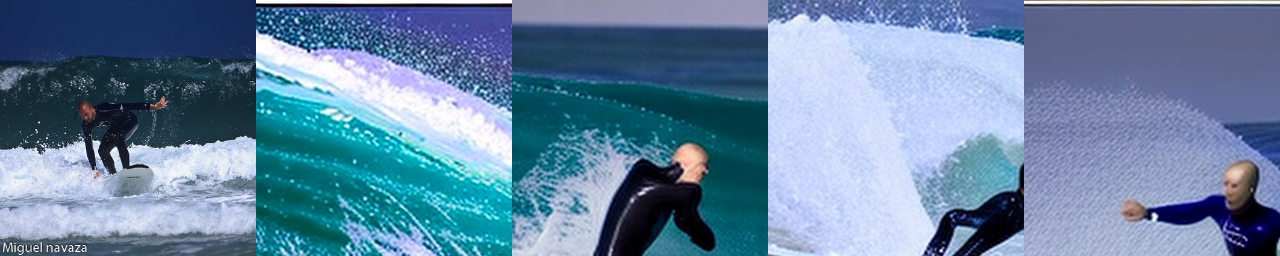

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.22it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


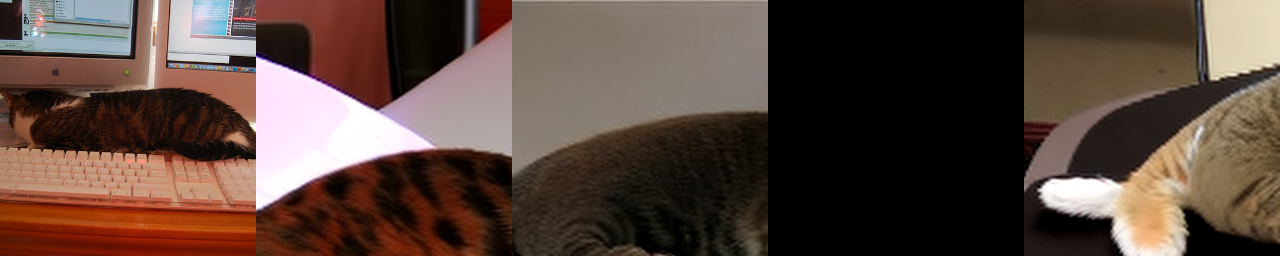

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.20it/s]


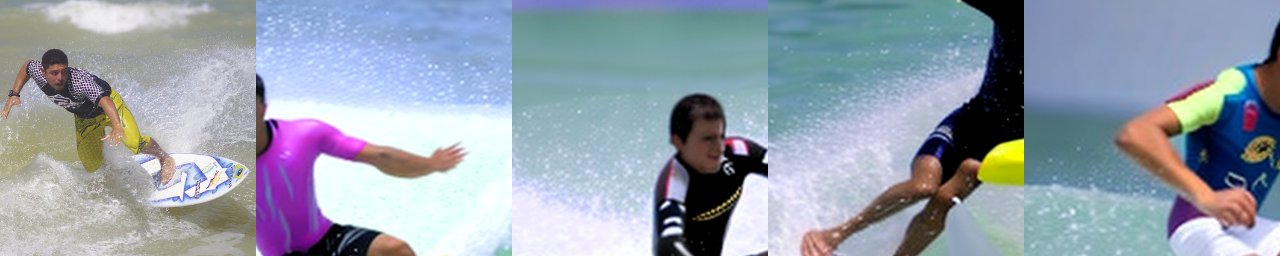

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


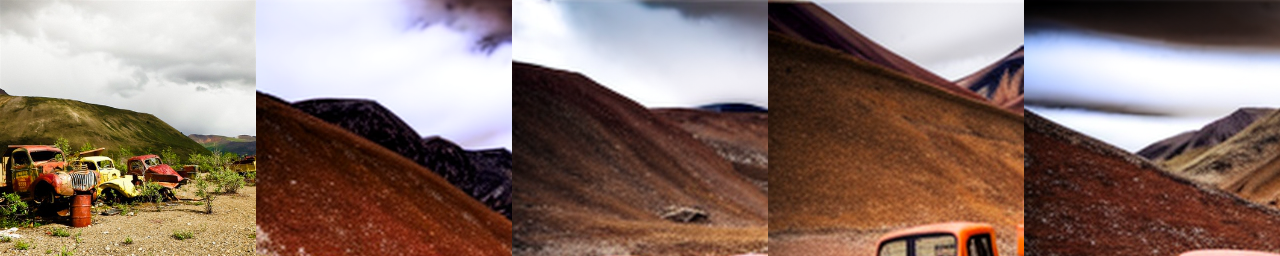

In [17]:
seed_everything(0)

for i in range(4):
    im = val_image0[i]
    inp = tform(im).to(device).unsqueeze(0)
    out = sd_pipe(inp, num_inference_steps=50, guidance_scale=7.5, num_images_per_prompt=n_variations)
    display(image_grid([torch_to_Image(im)] + out.images, 1, n_variations + 1))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


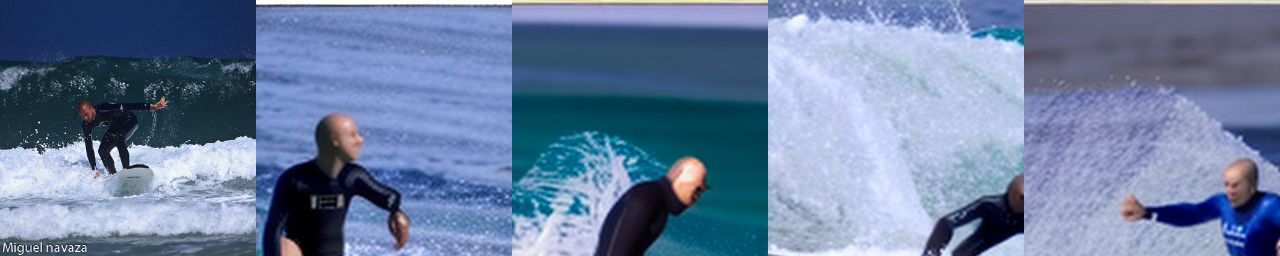

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


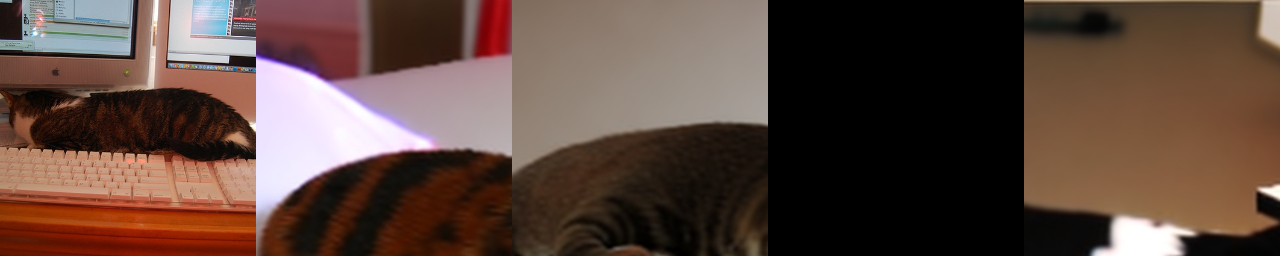

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


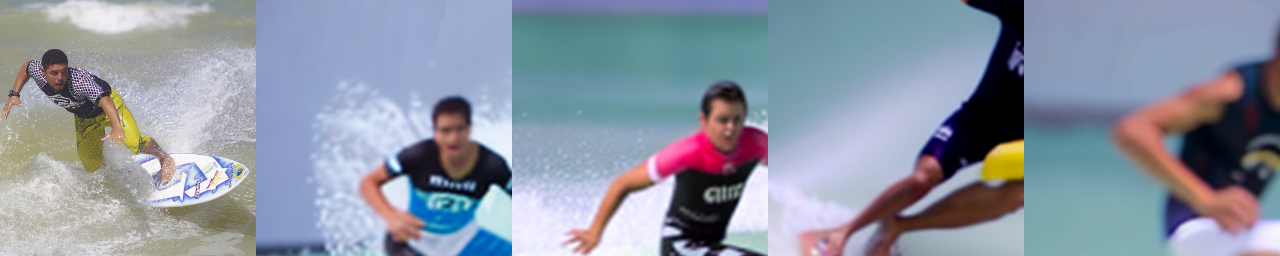

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


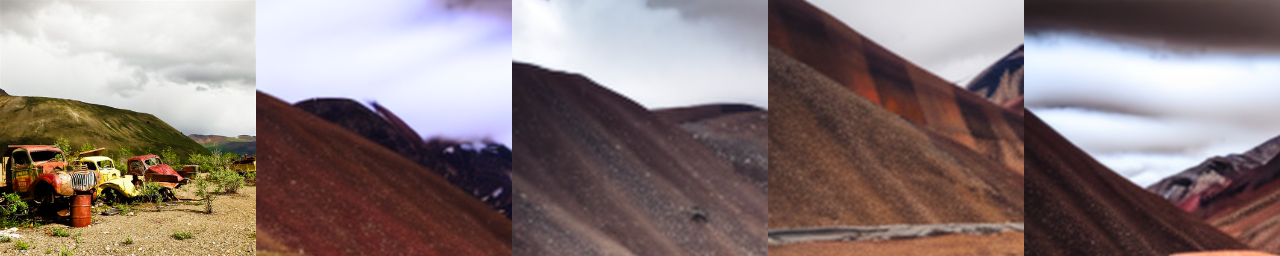

In [18]:
# use clip_extractor instead of tform
seed_everything(0)

for i in range(4):
    im = val_image0[i]
    #inp = tform(im).to(device).unsqueeze(0)
    inp = clip_extractor.resize_image(im.unsqueeze(0))
    inp = clip_extractor.normalize(inp)
    out = sd_pipe(inp, num_inference_steps=50, guidance_scale=7.5, num_images_per_prompt=n_variations)
    display(image_grid([torch_to_Image(im)] + out.images, 1, n_variations + 1))